# DDPM

> Denoising algorithm with callbacks for viz

In [1]:
#| default_exp ddpm

In [2]:
# |export
import math

import lightning as L
import torch
import torchvision
from lightning.pytorch.loggers import WandbLogger
from torch import tensor
from tqdm import tqdm

import wandb
from slow_diffusion.data import noisify, show_images, ᾱ
from slow_diffusion.fashionmnist import FashionMNISTDataModule
from slow_diffusion.training import UnetLightning

/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# |export
def denoisify(x_t, noise, t):
    return (x_t - (1 - ᾱ(t)).sqrt() * noise) / ᾱ(t).sqrt()

In [4]:
# |export
@torch.no_grad()
def ddpm(model, sz, n_steps, device=None):
    x_t = torch.randn(sz)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps)
    bs, *_ = x_t.shape
    if device:
        x_t = x_t.to(device)
        ts = ts.to(device)
    for t, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        t = t.repeat(bs)
        t_next = t_next.repeat(bs)
        noise_pred = model(x_t, t)
        x_0_pred = denoisify(x_t, noise_pred, t)
        (prev_sample, _), _ = noisify(x_0_pred, t_next)
        x_t = prev_sample

    t = tensor(0.0, device=device).repeat(bs)
    x_0 = denoisify(x_t, model(x_t, t), t)

    return x_0

In [5]:
def get_tiny_unet():
    return UnetLightning(
        nfs=(224, 448, 672, 896),
        n_blocks=(3, 2, 2, 1, 1),
        color_channels=1,
    )

100%|██████████████████| 1/1 [00:00<00:00,  1.45time step/s]


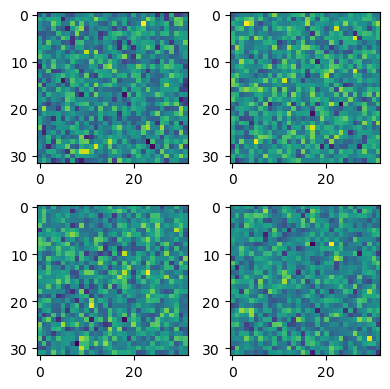

In [6]:
out = ddpm(get_tiny_unet().unet, (4, 1, 32, 32), 2)
show_images(out);

In [7]:
# |export
class DDPMCallback(L.Callback):
    def __init__(self, n_imgs=4, n_steps=100):
        super().__init__()
        self.n_imgs = n_imgs
        self.n_steps = n_steps

    def on_train_epoch_end(self, trainer, pl_module):
        sz = (
            self.n_imgs,
            pl_module.hparams.color_channels,
            *trainer.datamodule.img_size,
        )
        x_0 = (
            ddpm(pl_module.unet, sz, self.n_steps, device=pl_module.device)
            .cpu()
            .numpy()
        )
        wandb.log({"samples": show_images(x_0)})

In [8]:
# |exports
class TinyFashionMNISTDataModule(FashionMNISTDataModule):
    def post_process(self, ds):
        return ds["train"].select(range(100)).train_test_split(test_size=0.5)

In [ ]:
with wandb.init():
    dm = TinyFashionMNISTDataModule(32, n_workers=0)
    dm.setup()
    wandb_logger = WandbLogger()
    trainer = L.Trainer(
        max_epochs=1, callbacks=[DDPMCallback(n_steps=2)], logger=wandb_logger
    )
    trainer.fit(model=get_tiny_unet(), datamodule=dm)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jfisher40. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is sma

Sanity Checking DataLoader 0:   0%|   | 0/2 [00:00<?, ?it/s]

/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|████| 2/2 [00:06<00:00,  0.29it/s, v_num=9zi6]
Validation: |                         | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|        | 0/2 [00:00<?, ?it/s]
Validation DataLoader 0:  50%|▌| 1/2 [00:00<00:00,  1.59it/s
Validation DataLoader 0: 100%|█| 2/2 [00:01<00:00,  1.36it/s
Epoch 0: 100%|████| 2/2 [00:08<00:00,  0.23it/s, v_num=9zi6]


100%|██████████████████| 1/1 [00:00<00:00,  1.36time step/s]

Success :)

![wandb](../docs/wandb_interface_samples.jpg)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()